In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn2
from matplotlib import gridspec 


from matplotlib.lines import Line2D
import pickle

In [2]:

d = -1
u = 1

rna = pd.DataFrame()
for f in ['AR', 'SMARCC2sg1', 'SMARCC2sg2', 'GSE138460', 'GSE123379', 'SMARCC2']:
	tmp = pd.read_table(f"data/rna/deg/{f}.tsv")
	#tmp["log2FoldChange"] = -1
	tmp["Dataset"] = f

	tmp['DE'] = 'NS'

	tmp.loc[(tmp["log2FoldChange"] > u) & (tmp["padj"] < 0.05), "DE"] = "Pos"
	tmp.loc[(tmp["log2FoldChange"] < d) & (tmp["padj"] < 0.05), "DE"] = "Neg"


	rna = pd.concat([rna, tmp])

rna["lQ"] = -np.log10(rna["padj"])
rna = rna[~rna["lQ"].isna()]

/home/ualtintas/miniconda/envs/notebook/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


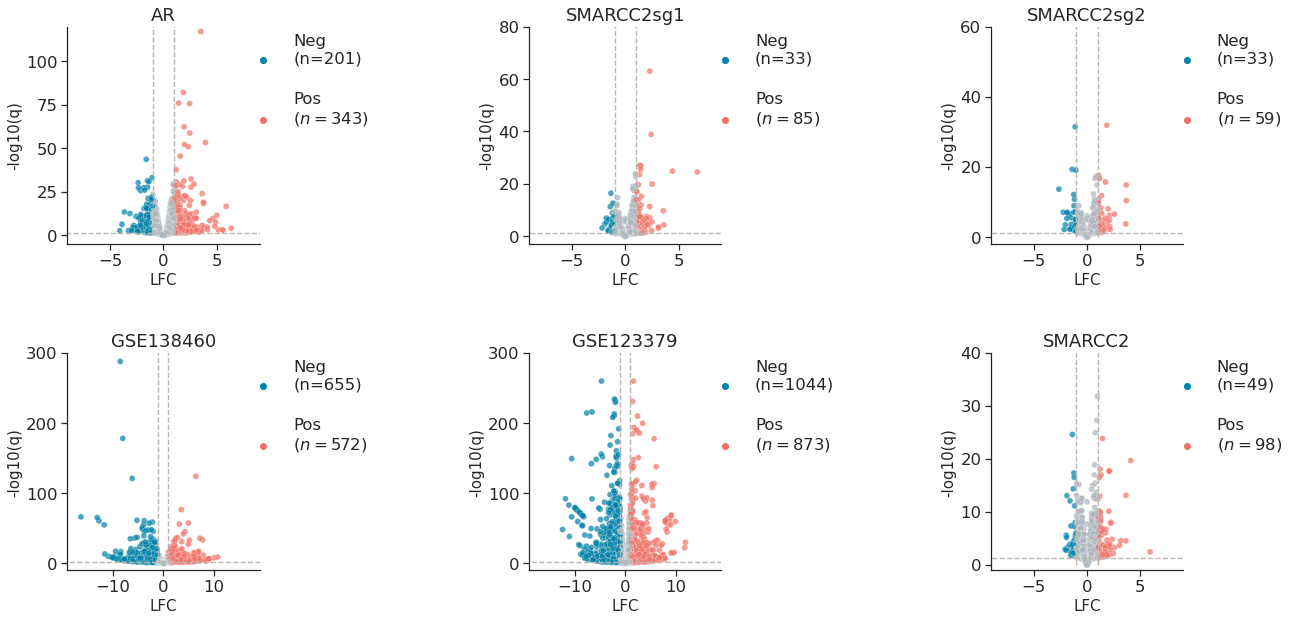

In [3]:
fig = plt.figure(figsize=[20,10])
gs = gridspec.GridSpec(nrows=2, ncols=3)
plt.subplots_adjust(hspace=0.5, wspace=1.4)

sns.set(style="ticks", font_scale=1.5)

ylims = [(-5, 120), (-3, 80), (-2, 60), (-10, 300), (-10, 300), (-1,40)]
xlims = [(-9,9),(-9,9),(-9,9),(-19,19),(-19,19),(-9,9)]
for i, c in enumerate(rna['Dataset'].unique()):
	fig.add_subplot(gs[i])
	d = rna[(rna["Dataset"] == c)]
	g = sns.scatterplot(data=d, 
					x="log2FoldChange", 
					y="lQ", 
					hue="DE", 
					hue_order=["Neg", "NS", "Pos"], 
					palette = ["#0081a7", "#adb5bd", "#f07167"],
					linewidth=0.3,
					alpha=0.7
	)
	plt.title(c, fontsize=18)
	xlim = int(max(abs(rna["log2FoldChange"].min()), rna["log2FoldChange"].max() )) + 1
	plt.xlim([-xlim-0.5, xlim-0.5])

	handles, labels = g.get_legend_handles_labels()
	[handles[0],handles[2]]
	[labels[0],labels[2]]
	sns.despine()

	nneg = d.groupby("DE").size()["Neg"]
	npos = d.groupby("DE").size()["Pos"]

	g.legend(
		handles=[handles[0],handles[2]], 
		labels=[f"Neg\n(n={nneg})\n ", f"Pos\n$(n={npos})$\n"], 
		title="",
		bbox_to_anchor=(0.9, 1), 
		loc=2, 
		borderaxespad=0,
		frameon=False
	)

	
	plt.ylabel("-log10(q)", fontsize=15)
	plt.xlabel("LFC", fontsize=15)
	
	ylim = 350
	#ylim = int(d["lQ"].max())+5

	plt.plot(range(-20, 20), [-np.log10(0.05) for i in range(-20, 20)], color='#bcb8b1', linestyle='--',linewidth=1.4)
	plt.plot([ 1 for i in range(ylim)], range(ylim), color='#bcb8b1', linestyle='--',linewidth=1.4)
	plt.plot([-1 for i in range(ylim)], range(ylim), color='#bcb8b1', linestyle='--',linewidth=1.4)

	plt.ylim(ylims[i])
	plt.xlim(xlims[i])

sns.despine()



fig.savefig("plot/rna.volcano.pdf", bbox_inches="tight", pad_inches=1)


# Venns

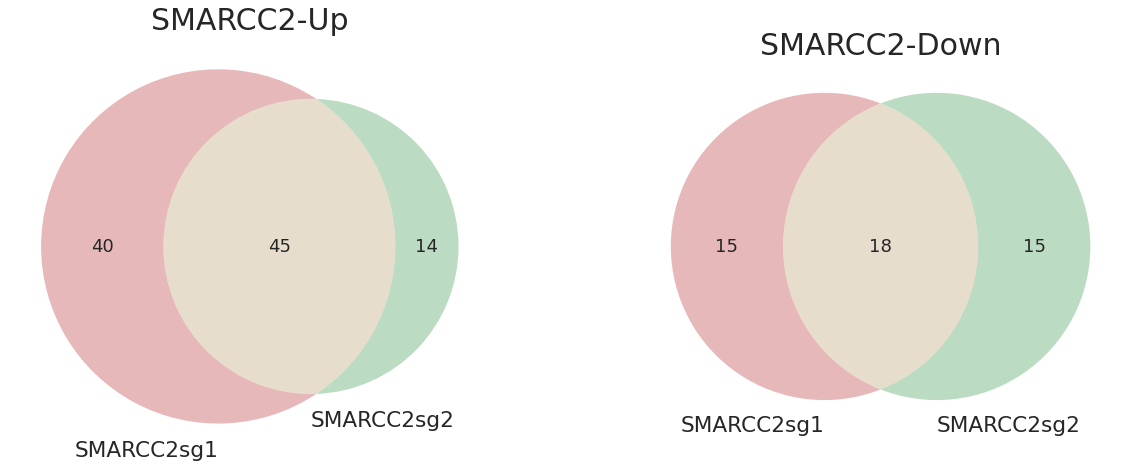

In [4]:

fig  = plt.figure(figsize=[20,8])
gs = gridspec.GridSpec(nrows=1, ncols=2, wspace=0.3)

fig.add_subplot(gs[0])
venn2((
	set(rna[((rna['DE'] == 'Pos') & (rna['Dataset'] == 'SMARCC2sg1'))].index),
	set(rna[((rna['DE'] == 'Pos') & (rna['Dataset'] == 'SMARCC2sg2'))].index)
), set_labels=('SMARCC2sg1', 'SMARCC2sg2'))
plt.title('SMARCC2-Up', fontsize=30)

fig.add_subplot(gs[1])
venn2((
	set(rna[((rna['DE'] == 'Neg') & (rna['Dataset'] == 'SMARCC2sg1'))].index),
	set(rna[((rna['DE'] == 'Neg') & (rna['Dataset'] == 'SMARCC2sg2'))].index)
), set_labels=('SMARCC2sg1', 'SMARCC2sg2'))
plt.title('SMARCC2-Down', fontsize=30)


fig.savefig("plot/rna.degvenn_sma.pdf", bbox_inches="tight", pad_inches=1)


up_sma = set(rna[((rna['DE'] == 'Pos') & (rna['Dataset'] == 'SMARCC2sg1'))].index).intersection(set(rna[((rna['DE'] == 'Pos') & (rna['Dataset'] == 'SMARCC2sg2'))].index))
down_sma = set(rna[((rna['DE'] == 'Neg') & (rna['Dataset'] == 'SMARCC2sg1'))].index).intersection(set(rna[((rna['DE'] == 'Neg') & (rna['Dataset'] == 'SMARCC2sg2'))].index))

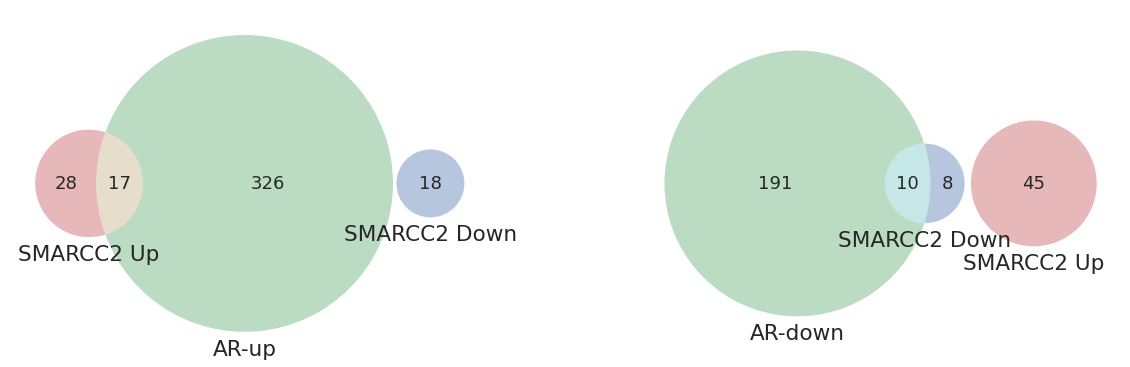

In [5]:

fig  = plt.figure(figsize=[20,8])
gs = gridspec.GridSpec(nrows=1, ncols=2, wspace=0.3)

fig.add_subplot(gs[0])
venn3((
	up_sma,
	set(rna[((rna['DE'] == 'Pos') & (rna['Dataset'] == 'AR'))].index),
	down_sma
), set_labels=('SMARCC2 Up','AR-up', 'SMARCC2 Down'))
#plt.title('AR-Up', fontsize=30)

fig.add_subplot(gs[1])
venn3((
	up_sma,
	set(rna[((rna['DE'] == 'Neg') & (rna['Dataset'] == 'AR'))].index),
	down_sma
), set_labels=('SMARCC2 Up','AR-down', 'SMARCC2 Down'))
#plt.title('AR-Up', fontsize=30)


fig.savefig("plot/rna.degvenn_ar.pdf", bbox_inches="tight", pad_inches=1)


up_ar = set(rna[((rna['DE'] == 'Pos') & (rna['Dataset'] == 'AR'))].index)
down_ar = set(rna[((rna['DE'] == 'Neg') & (rna['Dataset'] == 'AR'))].index)

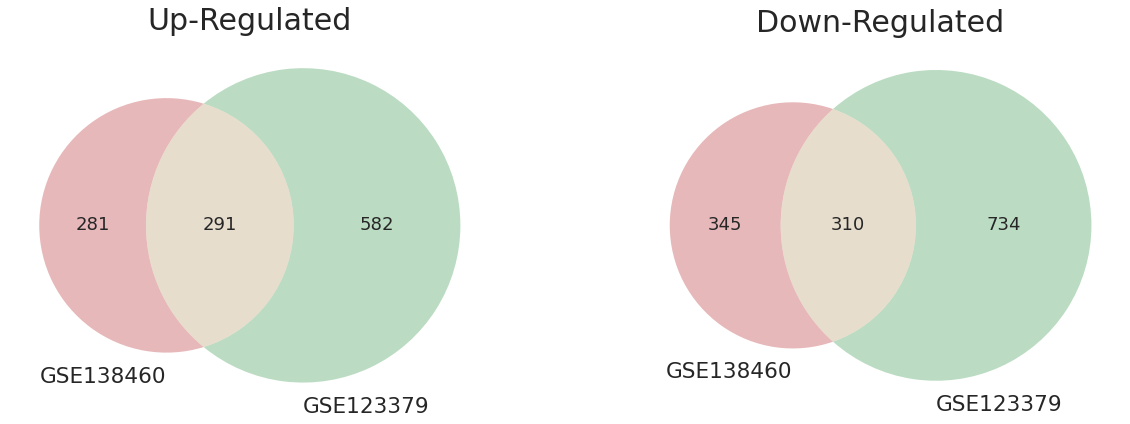

In [129]:

fig  = plt.figure(figsize=[20,8])
gs = gridspec.GridSpec(nrows=1, ncols=2, wspace=0.3)

fig.add_subplot(gs[0])
venn2((
	set(rna[((rna['DE'] == 'Pos') & (rna['Dataset'] == 'GSE138460'))].index),
	set(rna[((rna['DE'] == 'Pos') & (rna['Dataset'] == 'GSE123379'))].index)
), set_labels=('GSE138460', 'GSE123379'))
plt.title('Up-Regulated', fontsize=30)

fig.add_subplot(gs[1])
venn2((
	set(rna[((rna['DE'] == 'Neg') & (rna['Dataset'] == 'GSE138460'))].index),
	set(rna[((rna['DE'] == 'Neg') & (rna['Dataset'] == 'GSE123379'))].index)
), set_labels=('GSE138460', 'GSE123379'))
plt.title('Down-Regulated', fontsize=30)


fig.savefig("plot/rna.publicvenn.pdf", bbox_inches="tight", pad_inches=1)


up_public = set(rna[((rna['DE'] == 'Pos') & (rna['Dataset'] == 'GSE138460'))].index).intersection(set(rna[((rna['DE'] == 'Pos') & (rna['Dataset'] == 'GSE123379'))].index))
down_public = set(rna[((rna['DE'] == 'Neg') & (rna['Dataset'] == 'GSE138460'))].index).intersection(set(rna[((rna['DE'] == 'Neg') & (rna['Dataset'] == 'GSE123379'))].index))

# Heatmap

In [7]:


deg = list(set.union(up_ar, down_ar, up_sma, down_sma))
tmp = rna.loc[deg, :]
tmp = tmp[tmp['Dataset'].isin(['AR', 'SMARCC2sg1', 'SMARCC2sg2'])]
tmp = tmp[tmp['DE'] != 'NS']

tmp['GeneGroup'] = tmp['Dataset']

tmp.loc[tmp.index.isin(set.difference(up_ar.union(down_ar), up_sma.union(down_sma))), 'GeneGroup'] = 'AR'
tmp.loc[tmp.index.isin(set.difference(up_sma.union(down_sma), up_ar.union(down_ar))), 'GeneGroup'] = 'SMARCC2'

tmp.loc[tmp.index.isin(set.intersection(up_sma.union(down_sma), up_ar.union(down_ar))), 'GeneGroup'] = 'Common'


deg = tmp.reset_index().groupby(['DE', 'GeneGroup', 'index']).mean().sort_values(["GeneGroup", "DE",  "log2FoldChange"], ascending=False).reset_index()[['index', 'GeneGroup','log2FoldChange', 'DE']].set_index('index')
deg

,GeneGroup,log2FoldChange,DE
index,,,
LOC100421824,SMARCC2,3.622510,Pos
SPRY4,SMARCC2,2.312715,Pos
GMNC,SMARCC2,2.244711,Pos
TGM2,SMARCC2,2.009294,Pos
KCNC2,SMARCC2,1.771373,Pos
...,...,...,...
TMEM92,AR,-2.990771,Neg
LAPTM5,AR,-3.275092,Neg
TNXB,AR,-3.647820,Neg


In [8]:
orderGenes = deg.index

mat = pd.read_table('data/rna/normalized.tsv')
mat

Mat = mat.loc[orderGenes,:]

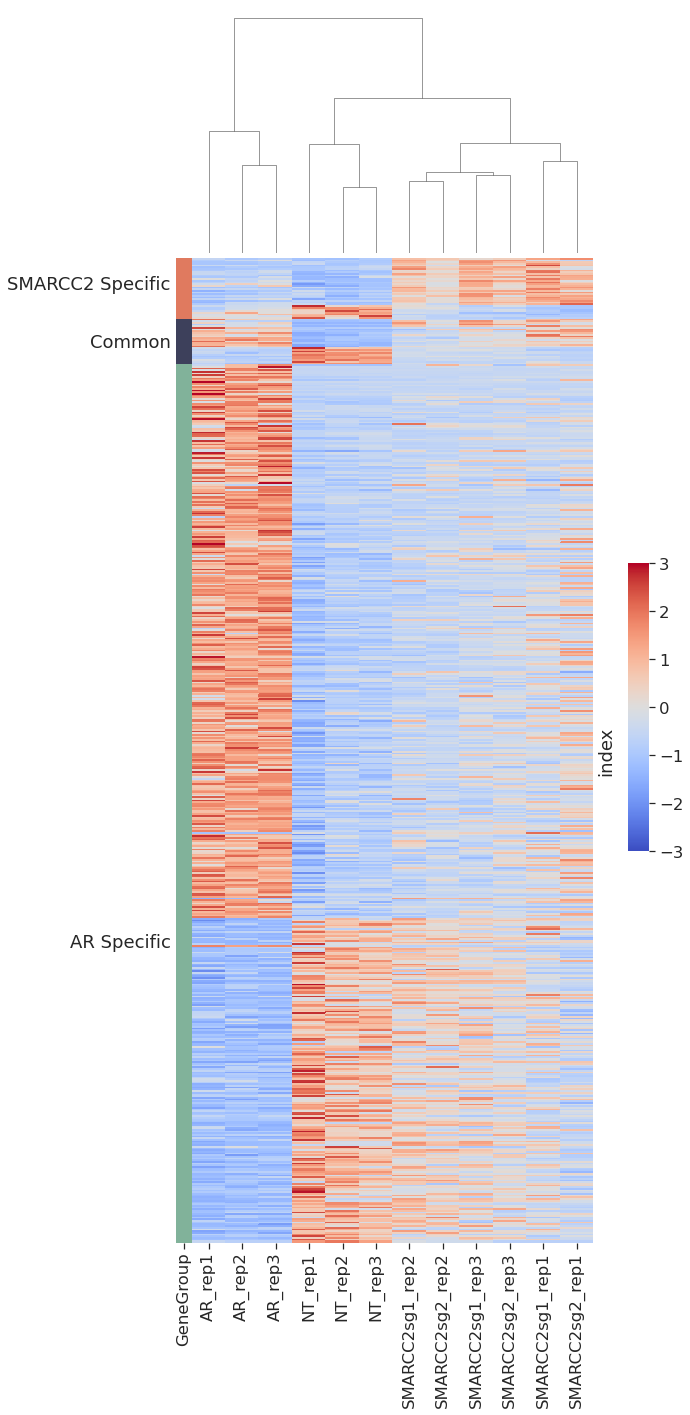

In [9]:
lut = dict(zip(deg["GeneGroup"].unique(),["#e07a5f", "#3d405b", "#81b29a"]))
row_colors = deg["GeneGroup"].map(lut)




cl = sns.clustermap(
    Mat,
    z_score=0,
    row_colors=row_colors, cmap="coolwarm", figsize=[10,20],
    row_cluster=False,
    col_cluster=True,
    vmax=3, vmin=-3,
    cbar_pos=(0.8, 0.4, 0.03, 0.2)
                
)

cl.cax.text(-130,-5, "AR Specific", ha="right", rotation=0)
cl.cax.text(-130,7.5, "Common",  ha="right", rotation=0)
cl.cax.text(-130,8.7, "SMARCC2 Specific",  ha="right", rotation=0)

cl.ax_heatmap.set_yticks([])


cl.fig.savefig("plot/rna.degheatmap.pdf", bbox_inches="tight", pad_inches=1)

# Gene Expression of AR and SMARCC2

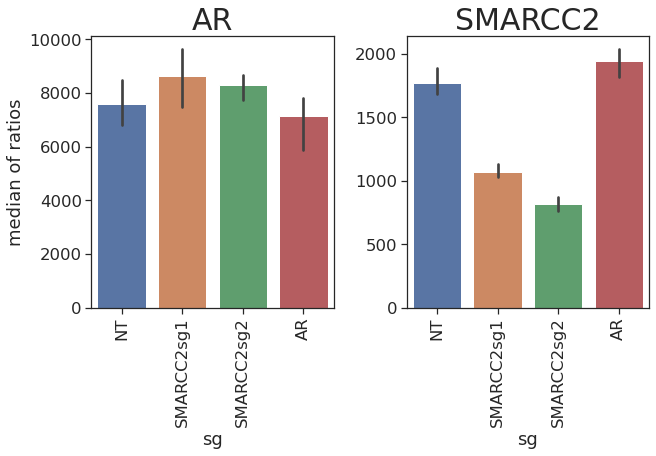

In [10]:

fig  = plt.figure(figsize=[10,5])
gs = gridspec.GridSpec(nrows=1, ncols=2, wspace=0.3)

fig.add_subplot(gs[0])
tmp = mat.loc['AR',:].reset_index()
tmp['sg'] = tmp['index'].str.split('_',expand=True)[0]
sns.barplot(data=tmp, x='sg', y='AR', order=['NT', 'SMARCC2sg1', 'SMARCC2sg2', 'AR'])
plt.title('AR',fontsize=30)
plt.xticks(rotation=90)
plt.ylabel('median of ratios')


fig.add_subplot(gs[1])
tmp = mat.loc['SMARCC2',:].reset_index()
tmp['sg'] = tmp['index'].str.split('_',expand=True)[0]
sns.barplot(data=tmp, x='sg', y='SMARCC2', order=['NT', 'SMARCC2sg1', 'SMARCC2sg2', 'AR'])
plt.xticks(rotation=90)
plt.title('SMARCC2',fontsize=30)
plt.ylabel('')


fig.savefig("plot/rna.tfexp.pdf", bbox_inches="tight", pad_inches=1)


Text(0, 0.5, '')

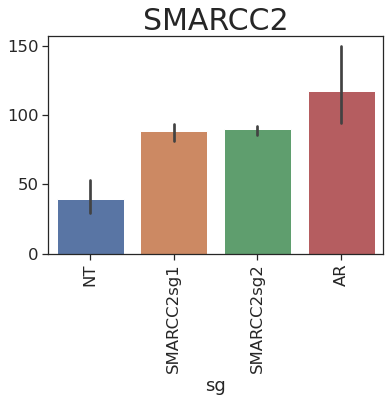

In [12]:
tmp = mat.loc['CRABP2',:].reset_index()
tmp['sg'] = tmp['index'].str.split('_',expand=True)[0]
sns.barplot(data=tmp, x='sg', y='CRABP2', order=['NT', 'SMARCC2sg1', 'SMARCC2sg2', 'AR'])
plt.xticks(rotation=90)
plt.title('SMARCC2',fontsize=30)
plt.ylabel('')


# GSEA

In [110]:

mat = pd.read_table('data/rna/normalized.tsv')
meta = pd.read_table("data/rna/metadata.tsv")
meta = meta[meta['Dataset'] == 'BG'].reset_index(drop='True')

In [111]:

for sg in ["AR", "SMARCC2sg1"]:
    filename = f"data/rna/gsea/{sg}.gct"
    
    cols = meta.loc[meta['Target'] == 'NT', 'Name'].tolist() + meta.loc[meta['Target'] == sg, 'Name'].tolist() 
    
    tmp = mat[cols]
    tmp = tmp.astype(str)
    with open(filename, "w") as f:
        f.write("#1.2\n")
        f.write(f"{tmp.shape[0]}\t{tmp.shape[1]}\n")
        f.write(f"NAME\tdecsription\t" + "\t".join(cols) + "\n")
        for name, row in tmp.iterrows():
            line = name +"\tNA\t" +"\t".join(row.tolist()) + "\n"
            f.write(line)
            

In [11]:
!tar -zcvf data/rna/gsea.tar.gz data/rna/gsea

data/rna/gsea/
data/rna/gsea/AR.cls
data/rna/gsea/SMARCC2.cls
data/rna/gsea/SMARCC2.Gsea.1694714259624/
data/rna/gsea/SMARCC2.Gsea.1694714259624/heat_map_221.png
data/rna/gsea/SMARCC2.Gsea.1694714259624/HALLMARK_ALLOGRAFT_REJECTION.html
data/rna/gsea/SMARCC2.Gsea.1694714259624/HALLMARK_DNA_REPAIR.tsv
data/rna/gsea/SMARCC2.Gsea.1694714259624/index.html
data/rna/gsea/SMARCC2.Gsea.1694714259624/HALLMARK_PANCREAS_BETA_CELLS.tsv
data/rna/gsea/SMARCC2.Gsea.1694714259624/enplot_HALLMARK_PANCREAS_BETA_CELLS_238.png
data/rna/gsea/SMARCC2.Gsea.1694714259624/gset_rnd_es_dist_225.png
data/rna/gsea/SMARCC2.Gsea.1694714259624/HALLMARK_KRAS_SIGNALING_UP.html
data/rna/gsea/SMARCC2.Gsea.1694714259624/enplot_HALLMARK_ESTROGEN_RESPONSE_LATE_241.png
data/rna/gsea/SMARCC2.Gsea.1694714259624/enplot_HALLMARK_KRAS_SIGNALING_DN_310.png
data/rna/gsea/SMARCC2.Gsea.1694714259624/HALLMARK_IL6_JAK_STAT3_SIGNALING.tsv
data/rna/gsea/SMARCC2.Gsea.1694714259624/enplot_HALLMARK_G2M_CHECKPOINT_235.png
data/rna/gsea/SMARC

# BAF regions around the genes

In [58]:
%%bash

annot=/groups/lackgrp/genomeAnnotations/hg38/hg38.ncbiRefSeq.simple.gtf

bedtools window -a <(tail -n+2 data/chip/baf.bed | sort -k1,1 -k2,2n --parallel=12) -b $annot -w 100000 > data/chip/baf.gene/window.100k

In [62]:

!grep $'\ttranscript\t' data/chip/baf.gene/window.100k > data/chip/baf.gene/window.100k.coding


In [13]:
!head data/chip/baf.gene/window.100k.coding


chr1	804693	805255	chr1:804693-805255.gBAF	chr1	ncbiRefSeq.2021-12-08	transcript	717621	720202	.	-	.	gene_id "SEPTIN14P14"; transcript_id "SEPTIN14P14";  gene_name "SEPTIN14P14";
chr1	804693	805255	chr1:804693-805255.gBAF	chr1	ncbiRefSeq.2021-12-08	transcript	722046	725822	.	+	.	gene_id "CICP3"; transcript_id "CICP3";  gene_name "CICP3";
chr1	804693	805255	chr1:804693-805255.gBAF	chr1	ncbiRefSeq.2021-12-08	transcript	758233	758336	.	-	.	gene_id "RNU6-1199P"; transcript_id "RNU6-1199P";  gene_name "RNU6-1199P";
chr1	804693	805255	chr1:804693-805255.gBAF	chr1	ncbiRefSeq.2021-12-08	transcript	803841	809798	.	+	.	gene_id "LINC01409"; transcript_id "XR_002958524.1";  gene_name "LINC01409";
chr1	804693	805255	chr1:804693-805255.gBAF	chr1	ncbiRefSeq.2021-12-08	transcript	803389	805749	.	+	.	gene_id "LINC01409"; transcript_id "XR_002958523.1";  gene_name "LINC01409";
chr1	804693	805255	chr1:804693-805255.gBAF	chr1	ncbiRefSeq.2021-12-08	transcript	826206	827522	.	-	.	gene_id "LINC00115"; transc

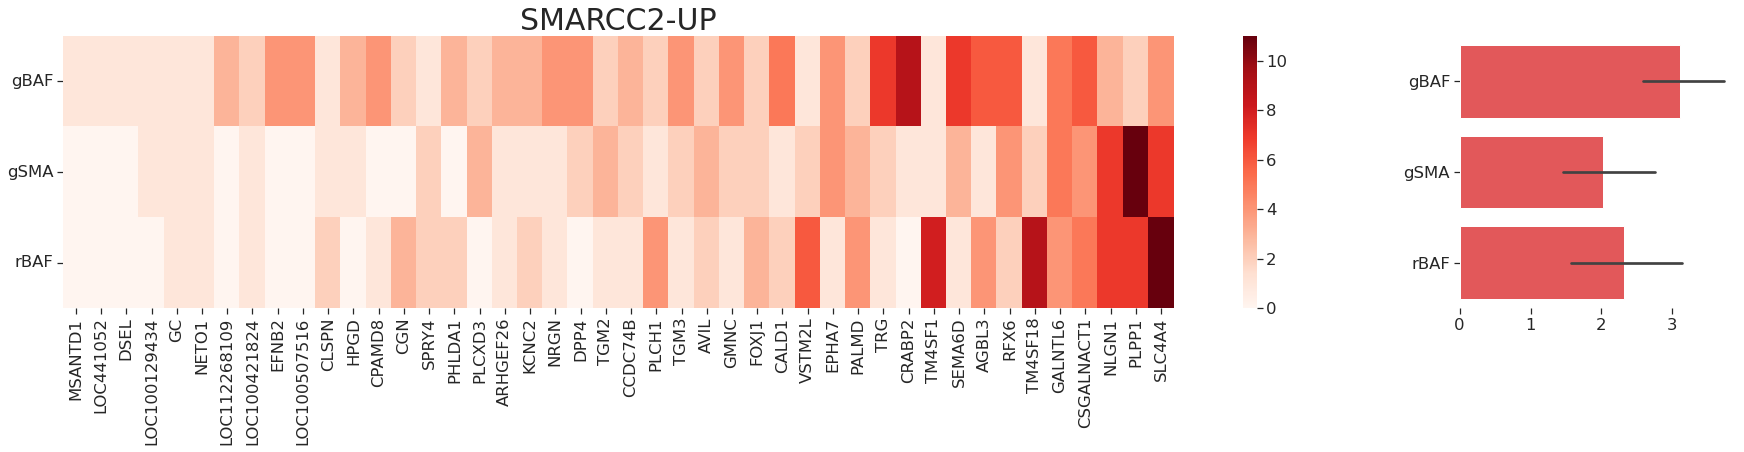

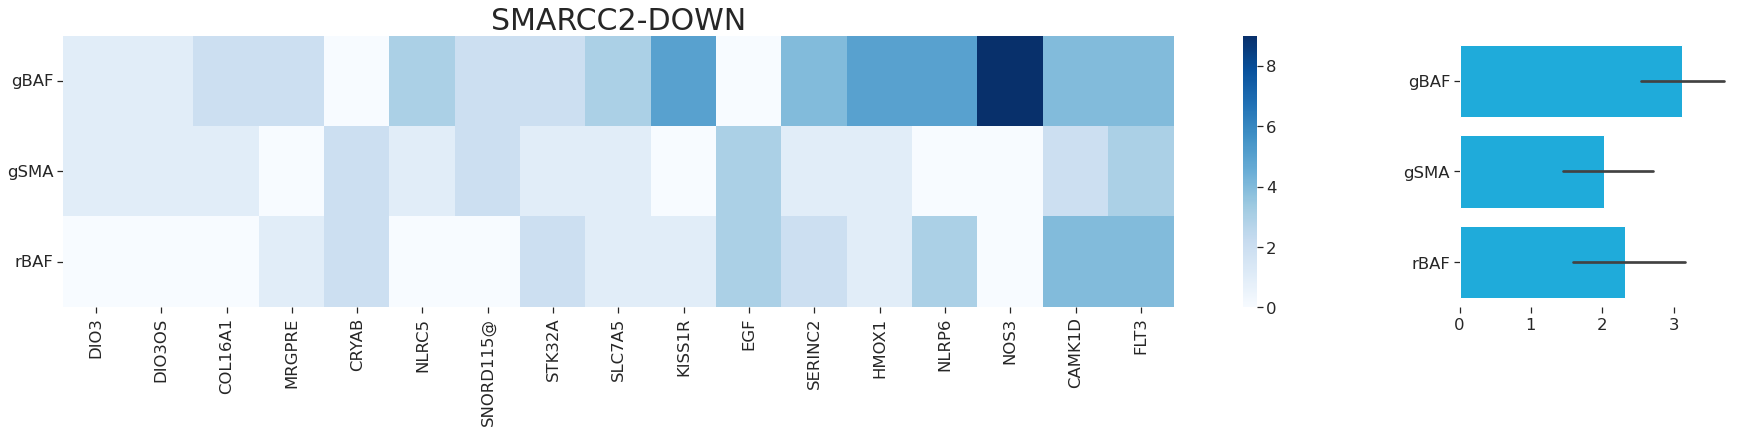

In [115]:

NEW = []
deg_genes = deg[deg['GeneGroup'].isin(['SMARCC2', 'Common'])].index
with open("data/chip/baf.gene/window.100k.coding","r") as f:
    for line in f.readlines():
        row = line.strip().split("\t")
        name, meta = row[3], row[12]
        nc = name.split(".")[-1]
        genename = meta[meta.index("gene_name"):].split("\"")[1]
        if genename in deg_genes:
            NEW.append((genename,nc, name) )
        

df = pd.DataFrame(NEW, columns=['Gene', 'nc', 'name'])
df = df.drop_duplicates().groupby(['Gene', 'nc']).size().reset_index().pivot(columns="Gene", index="nc", values=0).fillna(0).T
df['DE'] = df.index.map(dict(zip(deg.index, deg['DE'])))




fig = plt.figure(figsize=[30,5])
gs = gridspec.GridSpec(nrows=1, ncols=2, hspace=1, width_ratios=[10,2], wspace=0.01)

fig.add_subplot(gs[0])

tmp = df.loc[df['DE']=='Pos',['gBAF','gSMA', 'rBAF']].T
order = np.argsort(tmp.mean().tolist())

sns.heatmap(tmp.iloc[:, order], cmap='Reds')
plt.yticks(rotation=0)
plt.ylabel("")
plt.xlabel("")
plt.title('SMARCC2-UP', fontsize=30)


fig.add_subplot(gs[1])
t = df.loc[df['DE']=='Pos',['gBAF','gSMA', 'rBAF']].stack().reset_index()
sns.barplot(data=t, y="nc", x=0, color="#f94144", order=["gBAF", "gSMA", "rBAF"])

sns.despine(left=True, bottom=True)
plt.ylabel("")
plt.xlabel("")

fig.savefig("plot/rna.uparoundbaf.pdf", bbox_inches="tight", pad_inches=1)





fig = plt.figure(figsize=[30,5])
gs = gridspec.GridSpec(nrows=1, ncols=2, hspace=1, width_ratios=[10,2], wspace=0.01)

fig.add_subplot(gs[0])

tmp = df.loc[df['DE']=='Neg',['gBAF','gSMA', 'rBAF']].T
order = np.argsort(tmp.mean().tolist())


sns.heatmap(tmp.iloc[:, order], cmap='Blues')
plt.yticks(rotation=0)
plt.ylabel("")
plt.xlabel("")
plt.title('SMARCC2-DOWN', fontsize=30)

fig.add_subplot(gs[1])
t = df.loc[df['DE']=='Pos',['gBAF','gSMA', 'rBAF']].stack().reset_index()
sns.barplot(data=t, y="nc", x=0, color="#00bbf9", order=["gBAF", "gSMA", "rBAF"])

sns.despine(left=True, bottom=True)
plt.ylabel("")
plt.xlabel("")

fig.savefig("plot/rna.downaroundbaf.pdf", bbox_inches="tight", pad_inches=1)



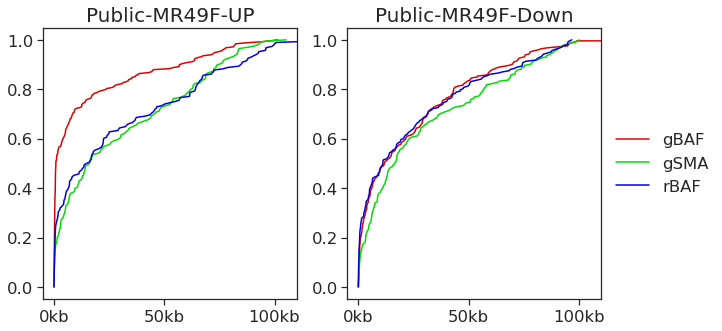

In [171]:




fig = plt.figure(figsize=[10,5])
gs = gridspec.GridSpec(nrows=1, ncols=2)


palette = ['#DD0000', '#00DD00', '#0000DD']



######################
fig.add_subplot(gs[0])
plt.title('Public-MR49F-UP', fontsize=20)
NEW = []
deg_genes = list(up_public)
with open("data/chip/baf.gene/window.100k.coding","r") as f:
    for line in f.readlines():
        row = line.strip().split("\t")
        b_start, b_end, name, g_start, g_end, meta = row[1], row[2], row[3], row[7], row[8], row[12]

        b_center = (int(b_start) + int(b_end)) // 2

        d = min(abs(b_center - int(g_start)), abs(b_center - int(g_end)))

        nc = name.split(".")[-1]
        genename = meta[meta.index("gene_name"):].split("\"")[1]
        if genename in deg_genes:
            NEW.append((genename,nc, name, d))
        

df = pd.DataFrame(NEW, columns=['Gene', 'nc', 'name', 'D']).drop_duplicates()
tmp = df.groupby(['Gene', 'nc']).min().reset_index()


for i, b in enumerate(['gBAF', 'gSMA', 'rBAF']):
    data = tmp.loc[(tmp['nc'] == b), 'D']
    x = np.sort(data)
    y = 1. * np.arange(len(data)) / (len(data) - 1)
    plt.plot(x, y, c=palette[i])
    plt.xticks([0, 50000, 100000], ['0kb', '50kb', '100kb'])
    plt.xlim(-5000, 1.1*10**5)
     


######################
fig.add_subplot(gs[1])
plt.title('Public-MR49F-Down', fontsize=20)
NEW = []
deg_genes = list(down_public)
with open("data/chip/baf.gene/window.100k.coding","r") as f:
    for line in f.readlines():
        row = line.strip().split("\t")
        b_start, b_end, name, g_start, g_end, meta = row[1], row[2], row[3], row[7], row[8], row[12]

        b_center = (int(b_start) + int(b_end)) // 2

        d = min(abs(b_center - int(g_start)), abs(b_center - int(g_end)))

        nc = name.split(".")[-1]
        genename = meta[meta.index("gene_name"):].split("\"")[1]
        if genename in deg_genes:
            NEW.append((genename,nc, name, d))
        

df = pd.DataFrame(NEW, columns=['Gene', 'nc', 'name', 'D']).drop_duplicates()
tmp = df.groupby(['Gene', 'nc']).min().reset_index()


for i, b in enumerate(['gBAF', 'gSMA', 'rBAF']):
    data = tmp.loc[(tmp['nc'] == b), 'D']
    x = np.sort(data)
    y = 1. * np.arange(len(data)) / (len(data) - 1)
    plt.plot(x, y, c=palette[i], label=b)
    plt.xticks([0, 50000, 100000], ['0kb', '50kb', '100kb'])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
    plt.xlim(-5000, 1.1*10**5)



fig.savefig("plot/rna.cdfpublic.pdf", bbox_inches="tight", pad_inches=1)




In [42]:
windows = {} 
ncs = {"gBAF":[], "rBAF":[], "gSMA":[]}
genesbed = {} 
NEW = {}
deg_genes = deg[deg['GeneGroup'].isin(['SMARCC2', 'Common'])].index
with open("data/chip/baf.gene/window.100k.coding","r") as f:
    for line in f.readlines():
        row = line.strip().split("\t")
        name, meta, Chr, Start, End = row[3], row[12], row[4], row[7], row[8]
        genename = meta[meta.index("gene_name"):].split("\"")[1]
        genesbed[genename] = (Chr, Start, End)
        if name not in windows:
            windows[name] = [genename]
        else:
            windows[name].append(genename)
            
        nc = name.split(".")[-1]
        ncs[nc].append(genename)

        if genename in deg_genes:
            if genename not in NEW:
                NEW[genename] = {'rBAF': 0, 'gBAF': 0, 'gSMA': 0}
            NEW[genename][nc] += 1
        
geneBED = pd.DataFrame(genesbed).T.rename(columns={0:"Chr", 1:"Start", 2:"End"})            
            
            
genesnc = {k:set(v) for k,v in ncs.items()}

for k, v in windows.items():
	windows[k] = list(set(v))



In [44]:
DEpeaks = {}

for name, genes in windows.items():
    
    tmp = any([_ in deg_genes for _ in genes])
    
    if tmp:
        DEpeaks[name] = set([_ for _ in genes if _ in deg_genes])
    
    

df = pd.DataFrame.from_dict(DEpeaks, "index").stack().reset_index()

df = df.rename(columns={"level_0":"Name", 0:"DEG"})[["DEG", "Name"]]

df["nodeClass"] = df["Name"].str.split(".", expand=True)[1]

df = df[df["nodeClass"] != "CRE"]

df

,DEG,Name,nodeClass
0,SERINC2,chr1:31413260-31414425.rBAF,rBAF
1,SERINC2,chr1:31416089-31417135.gBAF,gBAF
2,SERINC2,chr1:31470785-31473456.rBAF,rBAF
3,SERINC2,chr1:31474655-31475756.gBAF,gBAF
4,SERINC2,chr1:31482788-31483621.gBAF,gBAF
...,...,...,...
419,LOC100421824,chr8:53413870-53415481.gBAF,gBAF
420,LOC100507516,chr8:53413870-53415481.gBAF,gBAF
421,LOC100507516,chr8:53500660-53502283.gBAF,gBAF
422,LOC100507516,chr8:53564388-53564775.gBAF,gBAF


In [81]:
pdf = df.groupby(["DEG", "nodeClass"]).size().reset_index().pivot(columns="DEG", index="nodeClass", values=0).fillna(0)
pdf

DEG,AGBL3,ARHGEF26,AVIL,CALD1,CAMK1D,CCDC74B,CGN,CLSPN,COL16A1,CPAMD8,...,SLC7A5,SNORD115@,SPRY4,STK32A,TGM2,TGM3,TM4SF1,TM4SF18,TRG,VSTM2L
nodeClass,,,,,,,,,,,,,,,,,,,,,
gBAF,6.0,3.0,2.0,5.0,4.0,3.0,2.0,1.0,2.0,4.0,...,3.0,2.0,1.0,2.0,2.0,4.0,1.0,1.0,7.0,1.0
gSMA,1.0,1.0,3.0,1.0,2.0,2.0,0.0,1.0,1.0,0.0,...,1.0,2.0,2.0,1.0,3.0,2.0,1.0,2.0,2.0,2.0
rBAF,4.0,1.0,2.0,2.0,4.0,1.0,3.0,2.0,0.0,1.0,...,1.0,0.0,2.0,2.0,1.0,1.0,8.0,9.0,1.0,6.0


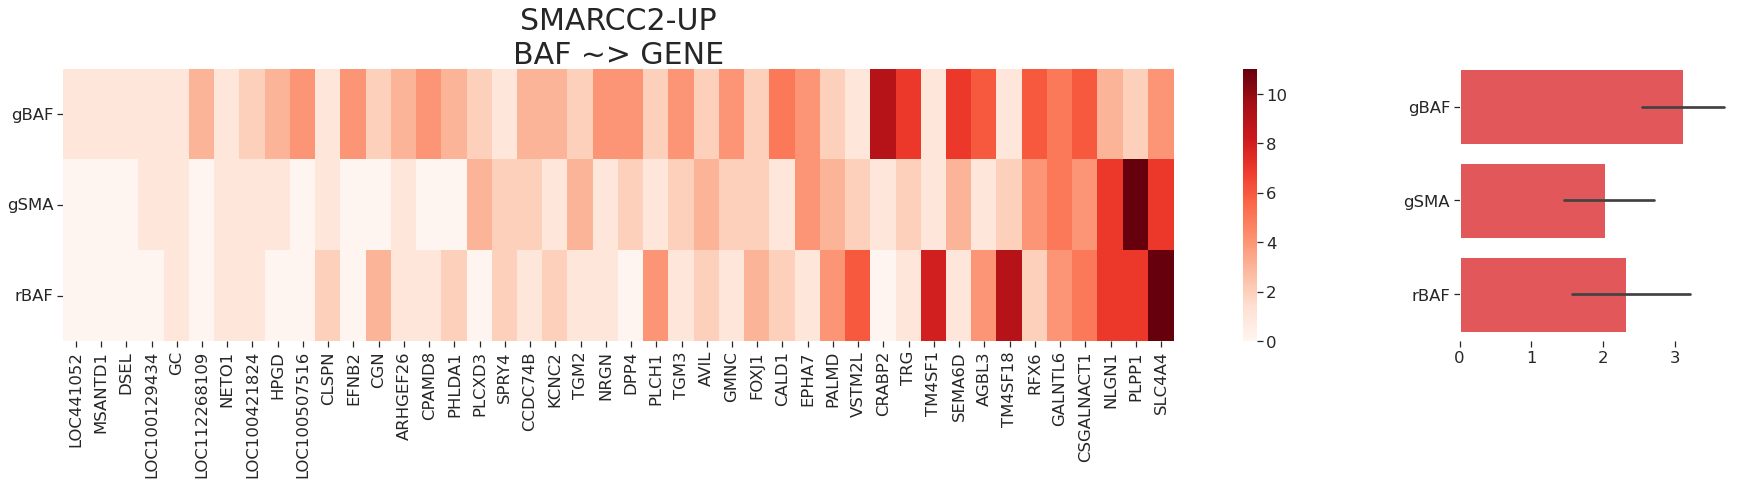

In [82]:
# This plot maps every BAF site to a gene. Instead of gene maps to BAF site.

ps = deg[deg['GeneGroup'].isin(['SMARCC2', 'Common']) & (deg['DE'] == 'Pos')].index.tolist()

exclude = ['MAP1A']
ps = np.delete(ps, np.isin(ps,exclude))
tmp = pdf[ps]

order = np.argsort(tmp.mean().tolist())



fig = plt.figure(figsize=[30,5])
gs = gridspec.GridSpec(nrows=1, ncols=2, hspace=1, width_ratios=[10,2], wspace=0.01)

fig.add_subplot(gs[0])
sns.heatmap(tmp.iloc[:,order], cmap="Reds")
plt.yticks(rotation=0)
plt.xlabel("")
plt.ylabel("")
plt.title('SMARCC2-UP\nBAF ~> GENE', fontsize=30)

fig.add_subplot(gs[1])
t = tmp.T.stack().reset_index()
sns.barplot(data=t, y="nodeClass", x=0, color="#f94144", order=["rBAF", "gSMA", "gBAF"])

plt.ylim((-0.5,2.4))
sns.despine(left=True, bottom=True)
#plt.yticks([])
plt.ylabel("")
plt.xlabel("")



fig.savefig("plot/rna.uparoundbaf.pdf", bbox_inches="tight", pad_inches=1)



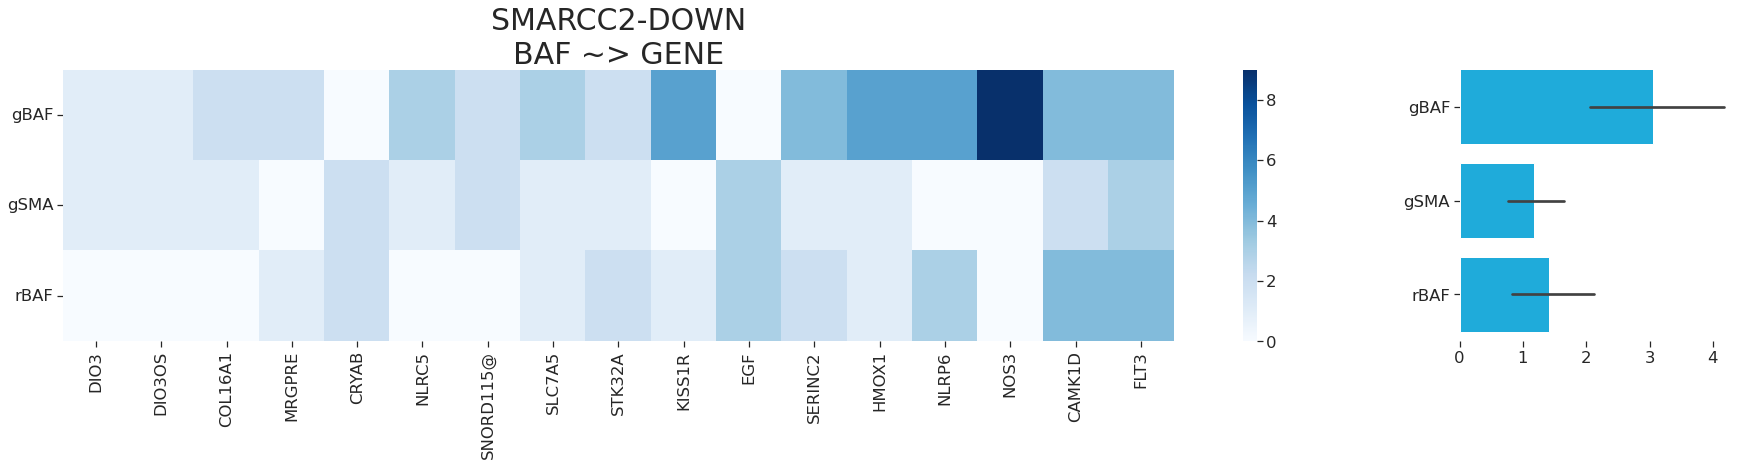

In [85]:
# This plot maps every BAF site to a gene. Instead of gene maps to BAF site.

ps = deg[deg['GeneGroup'].isin(['SMARCC2', 'Common']) & (deg['DE'] == 'Neg')].index.tolist()

exclude = ['MUC20']
ps = np.delete(ps, np.isin(ps,exclude))
tmp = pdf[ps]

order = np.argsort(tmp.mean().tolist())



fig = plt.figure(figsize=[30,5])
gs = gridspec.GridSpec(nrows=1, ncols=2, hspace=1, width_ratios=[10,2], wspace=0.01)

fig.add_subplot(gs[0])
sns.heatmap(tmp.iloc[:,order], cmap="Blues")
plt.yticks(rotation=0)
plt.xlabel("")
plt.ylabel("")
plt.title('SMARCC2-DOWN\nBAF ~> GENE', fontsize=30)

fig.add_subplot(gs[1])
t = tmp.T.stack().reset_index()
sns.barplot(data=t, y="nodeClass", x=0, color="#00bbf9", order=["rBAF", "gSMA", "gBAF"])

plt.ylim((-0.5,2.4))
sns.despine(left=True, bottom=True)
#plt.yticks([])
plt.ylabel("")
plt.xlabel("")



fig.savefig("plot/rna.downaroundbaf.pdf", bbox_inches="tight", pad_inches=1)



<AxesSubplot:>

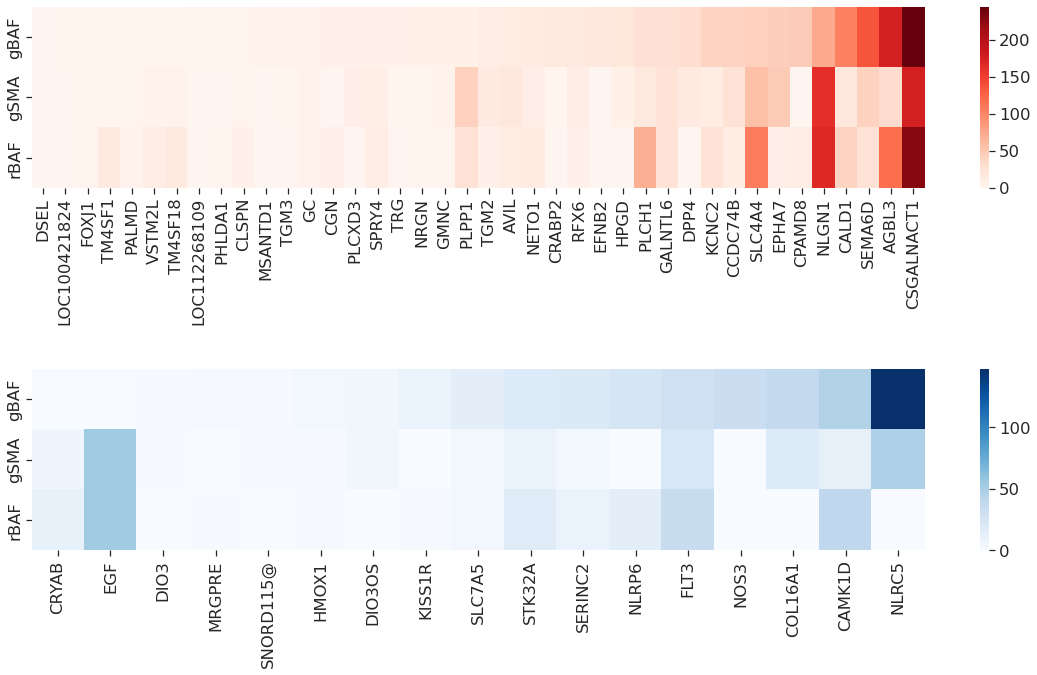

In [47]:
gene_regulated = pd.DataFrame(NEW).T


gene_regulated = gene_regulated.drop_duplicates()
gene_regulated['DE'] = gene_regulated.index.map(dict(zip(deg.index, deg['DE'])))

gene_regulated = gene_regulated.sort_values(['gBAF','gSMA','rBAF'])


fig = plt.figure(figsize=[20,10])
gs = gridspec.GridSpec(nrows=2, ncols=1, hspace=1)

fig.add_subplot(gs[0])
sns.heatmap(gene_regulated.loc[gene_regulated['DE']=='Pos',['gBAF','gSMA', 'rBAF']].T, cmap='Reds')

fig.add_subplot(gs[1])
sns.heatmap(gene_regulated.loc[gene_regulated['DE']=='Neg',['gBAF','gSMA', 'rBAF']].T, cmap='Blues')





In [ ]:
gene_regulated = pd.DataFrame(NEW).T


gene_regulated = gene_regulated.drop_duplicates()
gene_regulated['DE'] = gene_regulated.index.map(dict(zip(deg.index, deg['DE'])))

gene_regulated = gene_regulated.sort_values(['gBAF','gSMA', 'rBAF'])


fig = plt.figure(figsize=[20,5])
sns.heatmap(gene_regulated.loc[gene_regulated['DE']=='Pos',['gBAF','gSMA', 'rBAF']].T, cmap='Reds')



In [71]:
NEW

{'PLA2G2A': {'rBAF': 5, 'gBAF': 10, 'gSMA': 0},
 'PLA2G5': {'rBAF': 12, 'gBAF': 24, 'gSMA': 0},
 'EPHA8': {'rBAF': 0, 'gBAF': 0, 'gSMA': 6},
 'E2F2': {'rBAF': 0, 'gBAF': 18, 'gSMA': 0},
 'GRHL3': {'rBAF': 6, 'gBAF': 6, 'gSMA': 12},
 'AUNIP': {'rBAF': 0, 'gBAF': 2, 'gSMA': 6},
 'EXTL1': {'rBAF': 0, 'gBAF': 6, 'gSMA': 0},
 'LAPTM5': {'rBAF': 0, 'gBAF': 4, 'gSMA': 2},
 'SERINC2': {'rBAF': 10, 'gBAF': 20, 'gSMA': 5},
 'TINAGL1': {'rBAF': 0, 'gBAF': 12, 'gSMA': 6},
 'COL16A1': {'rBAF': 0, 'gBAF': 38, 'gSMA': 19},
 'CLSPN': {'rBAF': 6, 'gBAF': 3, 'gSMA': 3},
 'CDC20-DT': {'rBAF': 4, 'gBAF': 10, 'gSMA': 10},
 'PIK3R3': {'rBAF': 48, 'gBAF': 72, 'gSMA': 0},
 'RAD54L': {'rBAF': 10, 'gBAF': 20, 'gSMA': 5},
 'SPATA6': {'rBAF': 18, 'gBAF': 49, 'gSMA': 71},
 'RAB3B': {'rBAF': 2, 'gBAF': 16, 'gSMA': 4},
 'ORC1': {'rBAF': 0, 'gBAF': 6, 'gSMA': 12},
 'DAB1': {'rBAF': 5, 'gBAF': 17, 'gSMA': 34},
 'GADD45A': {'rBAF': 6, 'gBAF': 12, 'gSMA': 6},
 'PTGFR': {'rBAF': 15, 'gBAF': 20, 'gSMA': 18},
 'LMO4': {'rB

In [68]:
windows.keys()

dict_keys(['chr1:804693-805255.gBAF', 'chr1:806272-806955.gBAF', 'chr1:807379-808381.gBAF', 'chr1:810965-812411.rBAF', 'chr1:814974-816349.rBAF', 'chr1:816864-817491.rBAF', 'chr1:904183-905582.rBAF', 'chr1:916468-917636.gBAF', 'chr1:923721-925635.rBAF', 'chr1:932765-933907.gBAF', 'chr1:940478-942665.gBAF', 'chr1:960729-961179.gBAF', 'chr1:966087-968006.gBAF', 'chr1:1012916-1013463.gSMA', 'chr1:1019581-1021342.gBAF', 'chr1:1058871-1060044.gBAF', 'chr1:1073387-1074276.gBAF', 'chr1:1109518-1110663.gSMA', 'chr1:1116496-1117065.gBAF', 'chr1:1131898-1133645.gBAF', 'chr1:1153470-1154445.gBAF', 'chr1:1162104-1166284.rBAF', 'chr1:1231022-1231826.gBAF', 'chr1:1236775-1237329.gBAF', 'chr1:1273533-1274338.gBAF', 'chr1:1281613-1282350.gBAF', 'chr1:1307148-1307763.gBAF', 'chr1:1308663-1310727.gBAF', 'chr1:1316840-1318967.gBAF', 'chr1:1348312-1348873.gBAF', 'chr1:1354796-1356541.gBAF', 'chr1:1374678-1375209.gBAF', 'chr1:1398667-1400360.gBAF', 'chr1:1406278-1408205.gBAF', 'chr1:1432561-1437298.gBAF', 

In [19]:
deg_our = list(deg[deg['Dataset'] == 'SMARCC2'].index)

DEpeaks_our = {}

for name, genes in windows.items():
    
    tmp = any([_ in deg_our for _ in genes])
    
    if tmp:
        DEpeaks_our[name] = set([_ for _ in genes if _ in deg_our])
    
    
uni_our = list()

for k, v in DEpeaks_our.items():
    s_ = k.split('.')[1]
    if s_ != 'gBAF':
        continue
    else:
        uni_our += list(v)
        

len(set(uni_our))




In [38]:
u_public = list(set(rna[(rna['Dataset'] == 'GSE138460') & (rna['DE'] == 'Pos')].index).intersection(rna[(rna['Dataset'] == 'GSE123379') & (rna['DE'] == 'Pos')].index))

d_public = list(set(rna[(rna['Dataset'] == 'GSE138460') & (rna['DE'] == 'Neg')].index).intersection(rna[(rna['Dataset'] == 'GSE123379') & (rna['DE'] == 'Neg')].index))


deg_public = u_public + d_public

DEpeaks_public = {}

for name, genes in windows.items():
    
    tmp = any([_ in deg_public for _ in genes])
    
    if tmp:
        DEpeaks_public[name] = set([_ for _ in genes if _ in deg_public])
    
    
uni_public = list()

for k, v in DEpeaks_public.items():
    s_ = k.split('.')[1]
    if s_ != 'gBAF':
        continue
    else:
        uni_public += list(v)
        

len(set(uni_public))
        

497

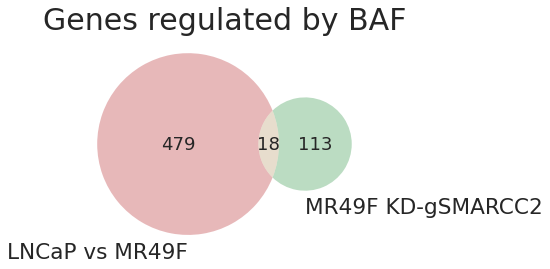

In [53]:
venn2((set(uni_public), set(uni_our)), set_labels=('LNCaP vs MR49F', 'MR49F KD-gSMARCC2'))

plt.title('Genes regulated by BAF', fontsize=30)


fig.savefig("plot/rna.baf.pdf", bbox_inches="tight", pad_inches=1)
